In [62]:
import praw
import json
import os
import matplotlib.pyplot as plt
import networkx as nx
from anytree import Node, RenderTree

import warnings 
warnings.filterwarnings('ignore')

In [8]:
client_id = 'wQEuOcq3Oxz8EJaf1hzigg'
client_secret = 'Walqn1Xz7h20dbvppmTcv16Fxl7uhg'
user_agent = 'sury-umanch'

In [54]:
def get_data_mets(file_path):
    data = json.load(open(file_path, 'r'))
    print("Title: ", data[0]['title'])

    def count_replies(comment):
        count = len(comment.get("replies", []))
        for reply in comment.get("replies", []):
            count += count_replies(reply)
        return count

    total_replies = 0
    total_comments = 0

    for post in data:
        for comment in post.get("comments", []):
            total_comments += 1
            total_replies += count_replies(comment)

    print("Total number of Comments: ", total_comments)
    print("Total number of Replies: ", total_replies)
    print("Average number of Replies: {:.3f}".format(total_replies/total_comments))

In [55]:
def display_renderTree(data):
    def build_tree(comment, parent_node):
        node = Node(comment["body"][:200].replace("\n", " "), parent=parent_node)
        for reply in comment.get("replies", []):
            build_tree(reply, node)

    root = Node("Post: " + data[0]['title'][:200])
    for comment in data[0]['comments'][:5]:  
        build_tree(comment, root)

    # Print tree
    for pre, fill, node in RenderTree(root):
        print(f"{pre}{node.name}")

In [56]:
def display_conversation_network(data, topic):
    G = nx.DiGraph()

    def add_comment_tree(graph, comment, parent_id, comment_id=0, level=0):
        node_label = f"{level}-{comment_id}: {comment['body'][:40].replace('\n',' ')}..."
        graph.add_node(node_label, level=level)
        if parent_id:
            graph.add_edge(parent_id, node_label)
        
        for idx, reply in enumerate(comment.get("replies", [])):
            add_comment_tree(graph, reply, node_label, idx, level+1)

   
    post = data[0]
    root_id = "Post: " + post["title"][:40] + "..."
    G.add_node(root_id, level=0)

    
    top_comment = post["comments"][0]
    add_comment_tree(G, top_comment, root_id)

    
    def hierarchy_pos(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):
        """Hierarchy layout like a top-down tree"""
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.successors(root))
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                                    vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root)
        return pos

    
    plt.figure(figsize=(14, 12))
    pos = hierarchy_pos(G, root_id)
    nx.draw(G, pos, with_labels=True, node_size=1600, node_color="#D0E1F9", font_size=8, font_weight="bold", arrows=True, edge_color="gray")
    plt.title(f"Reddit Thread Structure ({topic} - Sample Thread)", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [57]:
def extract_reddit_data(topic, save_path):
    reddit = praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent
    )

    
    subreddit = reddit.subreddit(topic)

    
    posts = []
    for submission in subreddit.hot(limit=1):
        submission_data = {
            'title': submission.title,
            # 'url': submission.url,
            # 'score': submission.score,
            # 'id': submission.id,
            # 'created': submission.created_utc,
            'comments': []
        }

        submission.comments.replace_more(limit=0)

        def get_comment_tree(comment):
            """ Recursively get comment and its replies """
            comment_data = {
                'body': comment.body,
                # 'score': comment.score,
                # 'id': comment.id,
                # 'created': comment.created_utc,
                'replies': []
            }
            for reply in comment.replies:
                comment_data['replies'].append(get_comment_tree(reply))
            return comment_data

        for i, top_level_comment in enumerate(submission.comments):
            submission_data['comments'].append(get_comment_tree(top_level_comment))

        posts.append(submission_data)

    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(posts, f, indent=2)

    print('Extracted Data saved at: ', save_path)
    get_data_mets(save_path)

    return

In [58]:
search_term = 'UKPolitics'
result_file_path = os.path.join('data', f'{search_term}_data.json')
# get_data_mets(result_file_path)
extract_reddit_data(search_term, result_file_path)

Extracted Data saved at:  data/UKPolitics_data.json
Title:  Weekly Rumours, Speculation, Questions, and Reaction Megathread - 30/03/25
Total number of Comments:  126
Total number of Replies:  369
Average number of Replies: 2.929


In [59]:
data = json.load(open(result_file_path, 'r'))

In [60]:
display_renderTree(data)

Post: Weekly Rumours, Speculation, Questions, and Reaction Megathread - 30/03/25
├── With this talk of Adolescence being shown in schools, I can't help but think it's a response that misses the point. The kids already know shit's fucked! Surely this show was made to be shown to the gr
│   ├── Now we just need a “gritty masterpiece” about NIMBYism.   A single shot starting with a boomer attending a council meeting to block the building of a new block of accessibility and age adapted flats a
│   │   └── Is the lack of punctuation in your second paragraph a metaphor for the single-shot take that will be required?
│   │       ├── It’s like Cormac McCarthy’s writing. Artistic genius
│   │       └── 😉
│   ├── Isn't it kind of condescending too? "Hey kids, here's a TV show some adults made about how you might end up murdering one of your classmates if you don't bring your screentime down below five hours"
│   │   └── It's like the most intense Grange Hill *issues* storyline ever.
│   ├── Yeah

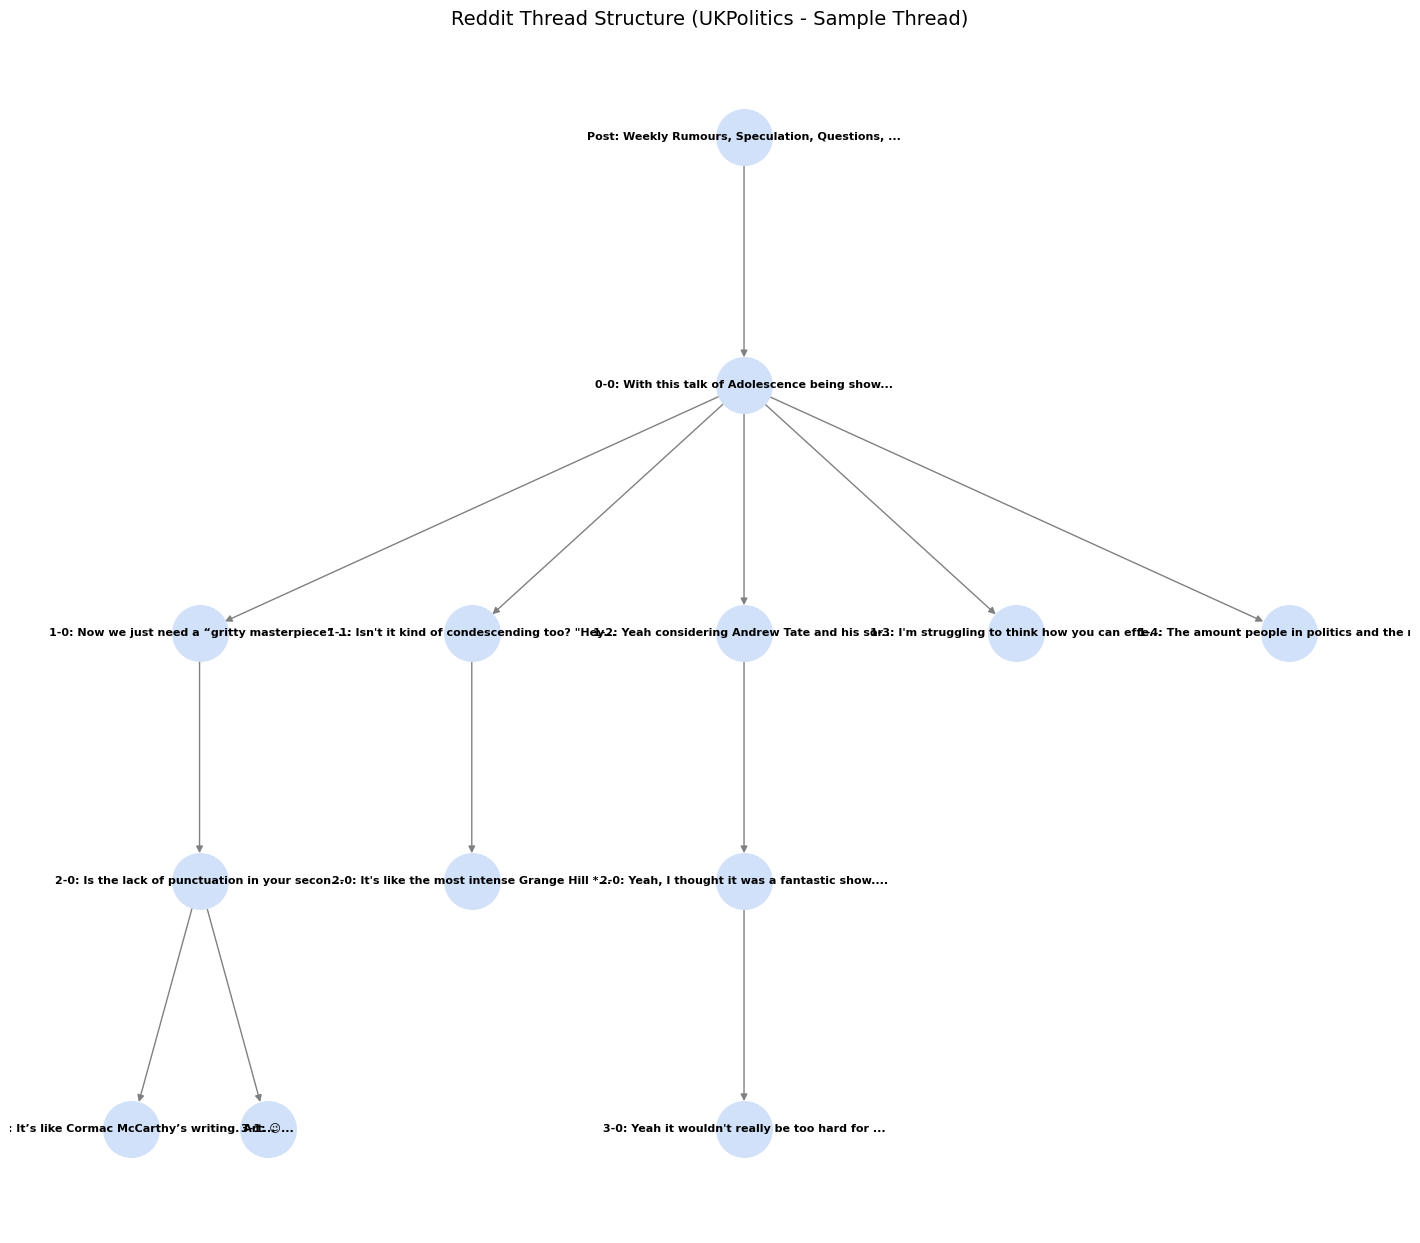

In [63]:
display_conversation_network(data, search_term)